In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
from src.models.lbcnn.lbc_unet import SkinnySmallUNetLBP, SmallUNetLBP
from src.models.unet.unet_model import SkinnySmallUNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, SkinnyDSCSmallUNetLBP
from src.models.dsc.dsc_unet import SkinnySmallUNetDSC, SmallUNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC, LargeAxialLBC
import torch
from src.datasets.ice import IceForVisualizing
import numpy as np
import os
from torch import nn
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
import torch.nn.functional as F
import matplotlib

In [2]:
latex = True
#plotting and colour set ups
if latex:
#     matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
#         'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [3]:
def eval_model(model: nn.Module, checkpoint_path: str, title: str, img_number, mobile: bool = False) -> None:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.train()
    out = nn.Softmax(dim=1)

    mask_list, pred_list = [], []

    img = val_set[img_number]['image'].to(device=device).unsqueeze(0)
    mask = val_set[img_number]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)
    img_orig = val_set[img_number]['img_orig'].to(device=device)

    if mobile:
        imgs = torch.stack([img, img], dim=0).squeeze(1)
        with torch.no_grad():
            output = model(imgs)['out']
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)[0].unsqueeze(0)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output[0].unsqueeze(0), mask.squeeze(1)).detach().item()
    else:
        with torch.no_grad():
            output = model(img)
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()
    print(model.__class__.__name__, iou, acc)
    
    img_np = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    img_orig_np = img_orig.permute(0, 2, 1).detach().cpu().numpy()
    mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
    return img_orig_np, mask_np, argmx_np

In [4]:
def plot_example(ax, img, is_img=False, x_label=None, y_label=None):
    ax.imshow(img, cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis=u'both', which=u'both',length=0)
#     ax.axis('off')
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label) # , rotation=0)
    
def plot_column(ind, img_number, epoch=10):
    x_label, y_label = None, None
    img, mask, pred = eval_model(
        UNet(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/frosty_sponge_239_unet_ice/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Image'
    plot_example(axs[0, ind], np.flipud(np.rot90(img)), x_label=x_label, y_label=y_label)
    if img_number==6:
        y_label = 'Ground Truth'
    plot_example(axs[1, ind], mask, x_label=x_label, y_label=y_label)
    if img_number==6:
        y_label = 'Full UNet'
    plot_example(axs[2, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        UNetDSC(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/helpful_fire_308_unet_dsc_ice/epoch{epoch}.pth', 
        'DSC UNet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Full DSC UNet'
    plot_example(axs[3, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        UNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/worthy_wood_227_lbc_unet_ice/epoch{epoch}.pth', 
        'LBC Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Full LBC UNet'
    plot_example(axs[4, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        DSCUNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/youthful_microwave_310_lbc_dsc_unet_ice/epoch{epoch}.pth', 
        'DSC LBC UNet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Full DSC LBC UNet'
    plot_example(axs[5, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SkinnySmallUNet(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/noble_forest_358_skinny_small_unet/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small UNet'
    plot_example(axs[6, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
         SkinnySmallUNetDSC(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/ancient_grass_357_skinny_small_dsc_unet/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small DSC UNet'
    plot_example(axs[7, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SkinnySmallUNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/trim_field_359_skinny_small_lbc_unet/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small LBC UNet'
    plot_example(axs[8, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SkinnyDSCSmallUNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/clear_lake_355_skinny_small_dsc_lbc_unet/epoch{epoch}.pth', 
        'DSC LBC Small UNet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small DSC LBC UNet'
    plot_example(axs[9, ind], pred, x_label=x_label, y_label=y_label)


    img, mask, pred = eval_model(
        deeplabv3_mobilenet_v3_large(num_classes=3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/vivid_donkey_305_deeplab_mobilenet_ice/epoch{epoch}.pth', 
        'DeepLab MobileNet, 80 epochs', img_number,
        mobile=True
    )
    if img_number==6:
        y_label = 'MobileNetV3 (DeepLabV3)'
    plot_example(axs[10, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        lraspp_mobilenet_v3_large(num_classes=3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/clean_darkness_312_laraspp_mobilenet_ice/epoch{epoch}.pth', 
        'LRASPP MobileNet, 80 epochs', img_number,
        mobile=True
    )
    if img_number==6:
        y_label = 'MobileNetV3 (LR-ASPP)'
    plot_example(axs[11, ind], pred, x_label=x_label, y_label=y_label)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


UNet tensor(0.5669, device='cuda:0') tensor(0.6782, device='cuda:0')
UNetDSC tensor(0.6152, device='cuda:0') tensor(0.7289, device='cuda:0')
UNetLBP tensor(0.5477, device='cuda:0') tensor(0.6673, device='cuda:0')
DSCUNetLBP tensor(0.5810, device='cuda:0') tensor(0.6925, device='cuda:0')
SkinnySmallUNet tensor(0.5499, device='cuda:0') tensor(0.6608, device='cuda:0')
SkinnySmallUNetDSC tensor(0.5415, device='cuda:0') tensor(0.6547, device='cuda:0')
SkinnySmallUNetLBP tensor(0.4799, device='cuda:0') tensor(0.6461, device='cuda:0')
SkinnyDSCSmallUNetLBP tensor(0.6520, device='cuda:0') tensor(0.7626, device='cuda:0')
DeepLabV3 tensor(0.4125, device='cuda:0') tensor(0.5415, device='cuda:0')
LRASPP tensor(0.6450, device='cuda:0') tensor(0.7764, device='cuda:0')
UNet tensor(0.6550, device='cuda:0') tensor(0.7823, device='cuda:0')
UNetDSC tensor(0.7028, device='cuda:0') tensor(0.8252, device='cuda:0')
UNetLBP tensor(0.5161, device='cuda:0') tensor(0.7112, device='cuda:0')
DSCUNetLBP tensor(0.56

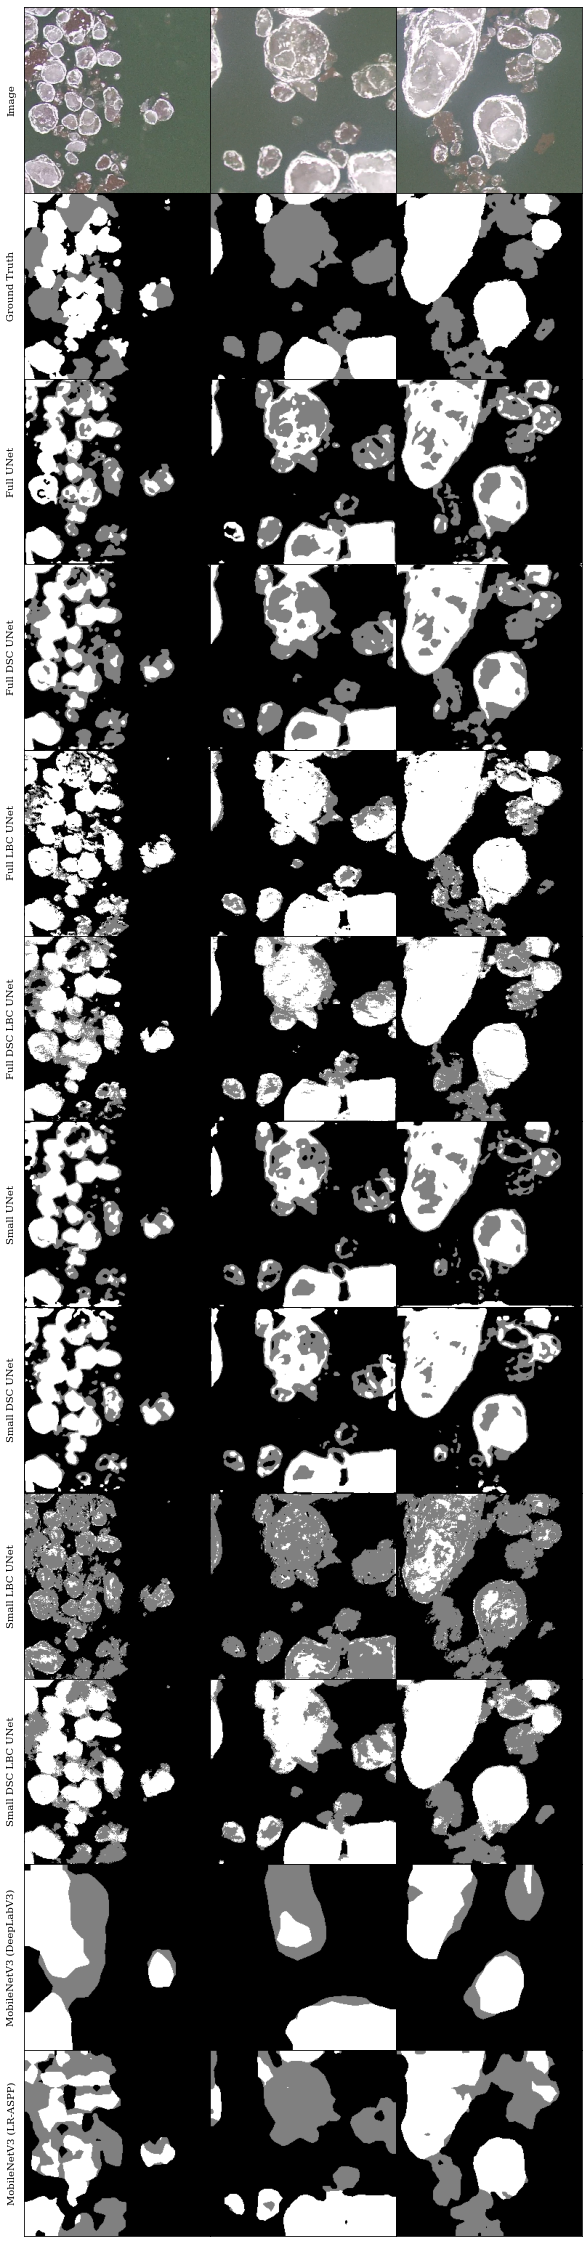

In [5]:
fig, axs = plt.subplots(12,3, figsize=(10, 41))

IMG_NUMBER = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_crop = 256
img_scale = 0.35

val_set = IceForVisualizing(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

plot_column(0, 6, epoch=2)
plot_column(1, 7, epoch=2)
plot_column(2, 8, epoch=2)
fig.subplots_adjust(wspace=0, hspace=0)

In [10]:
# fig.savefig("../images/pred_results_2_epochs.svg", format='svg', dpi=1200)

In [10]:
d=DSCSmallUNetLBP(3, 3)